In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.seasonal import seasonal_decompose

import yfinance as yf
import pandas_ta as ta
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model

import keras.backend as K
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
NAME = '0005.HK'

df = yf.download(NAME, start='2010-01-01', end = '2023-06-30')
df.reset_index(inplace=True)
df.drop('Close', axis=1, inplace=True)
df = df.rename(columns={'Adj Close': f'Close'})

[*********************100%***********************]  1 of 1 completed


In [3]:
def preprocess_data(df):
    null_sum = df['Close'].isnull().sum()
    print(f"null before: {null_sum}")

    df['Close'] = df['Close'].interpolate(method='linear')

    after_null_sum = df.isnull().sum()
    print(f"null after: {after_null_sum}")

    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.dayofweek

    # Adding indicators
    df['SMA_20'] = ta.sma(df['Close'], length=20, append=True)
    df['SMA_253'] = ta.sma(df['Close'], length=253, append=True)
    
    df['EMA_5'] = ta.ema(df['Close'], length=5, append=True)
    df['EMA_20'] = ta.ema(df['Close'], length=20, append=True)
    df['EMA_253'] = ta.ema(df['Close'], length=253, append=True)

    df['RSI_14'] = ta.rsi(df['Close'], length=14, append=True)

    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    df.ta.bbands(length=20, std=2, append=True)

    # feature engineering to prepare data
    df['Lag1_Price'] = df['Close'].shift(1) # create feature of past 1-day price
    df['Lag2_Price'] = df['Close'].shift(2) # past 2-days price

    # one-hot encode the Month and Day columns
    month_one_hot = pd.get_dummies(df['Month'], prefix='month', dtype=float)
    day_one_hot = pd.get_dummies(df['Day'], prefix='day', dtype=float)

    # concatenate the one-hot encoded columns to the original dataset
    df = pd.concat([df, month_one_hot, day_one_hot], axis=1)
    df = df.set_index(df['Date'])

    df.dropna(inplace=True)
    df.drop(columns=['Date', 'Month', 'Day'], axis=1, inplace=True)
    return df

In [4]:
sequence_length = 20
# function to calculate MAPE
def calculate_mape(y, y_pred):
    
  y_np = np.array(y)
  y_pred_np = np.array(y_pred)

  return round(np.mean(np.abs((y_np - y_pred_np) / y_np)) * 100, 4)

def eval_train_score(model, train_input, y_train):
    y_train_pred = model.predict(train_input).flatten()
    y_train_actual = np.array(y_train[sequence_length:])
    mape = calculate_mape(y_train_actual, y_train_pred)

    return mape

def eval_val_score(model, val_input, y_val):
    y_val_pred = model.predict(val_input).flatten()
    y_val_actual = np.array(y_val[sequence_length:])
    mape = calculate_mape(y_val_actual, y_val_pred)

    return y_val_pred, y_val_actual, mape

def plot_test(y_actual, y_pred):
    plt.title('Test Predictions')
    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show() # plotting prediction on test and actual prices

## Model Training
We train the model for the whole dataset right until the date we want to start the backtesting

In [5]:
# Init our model, a kNN classifier
df2 = preprocess_data(df.copy())
df2.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

train_df = df2.loc[:'2022-05-31']
val_df = df2.loc['2022-05-04':'2022-06-30']

X_train = train_df.drop('Close', axis=1)
y_train = train_df['Close']

X_val = val_df.drop('Close', axis=1)
y_val = val_df['Close']
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# create sequences of data using TimeseriesGenerator
sequence_length = 20
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=32)
val_generator = TimeseriesGenerator(X_val, y_val, length=sequence_length, batch_size=32)

null before: 0
null after: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# defining the model architecture
model = Sequential()

# adding LSTM layers
model.add(LSTM(units=64, input_shape=(sequence_length, X_train.shape[1]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.1))

# adding dense layer
model.add(Dense(units=1))

# compiling the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# training the model
model.fit(train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
88/88 [==============================] - 6s 27ms/step - loss: 1903.6813 - val_loss: 1529.2762
Epoch 2/100
88/88 [==============================] - 2s 18ms/step - loss: 1347.5593 - val_loss: 1253.6848
Epoch 3/100
88/88 [==============================] - 2s 18ms/step - loss: 1127.7012 - val_loss: 1054.9860
Epoch 4/100
88/88 [==============================] - 2s 18ms/step - loss: 954.0309 - val_loss: 887.7780
Epoch 5/100
88/88 [==============================] - 2s 18ms/step - loss: 807.3377 - val_loss: 744.9166
Epoch 6/100
88/88 [==============================] - 2s 18ms/step - loss: 683.1006 - val_loss: 622.1066
Epoch 7/100
88/88 [==============================] - 2s 18ms/step - loss: 576.9697 - val_loss: 517.5492
Epoch 8/100
88/88 [==============================] - 2s 18ms/step - loss: 485.3994 - val_loss: 427.3326
Epoch 9/100
88/88 [==============================] - 2s 19ms/step - loss: 404.6327 - val_loss: 351.1637
Epoch 10/100
88/88 [==============================] - 2s 1

88/88 [==============================] - 5s 9ms/step
Train MAPE:  2.2073
1/1 [==============================] - 0s 33ms/step
Val MAPE:  1.1834


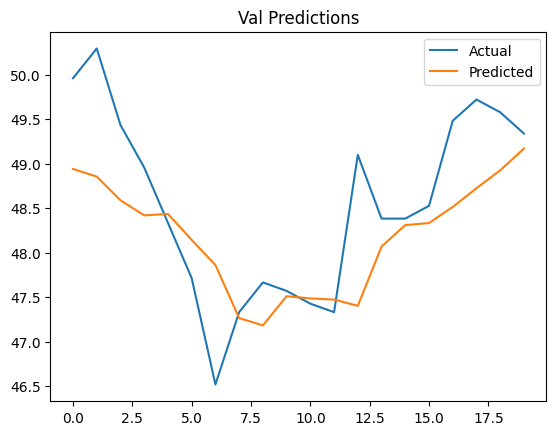

In [91]:
print("Train MAPE: ", eval_train_score(model, train_generator, y_train))

y_pred, y_actual, val_mape = eval_val_score(model, val_generator, y_val)
print("Val MAPE: ", val_mape)
plt.title('Val Predictions')
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show() # plotting prediction on val and actual prices

In [18]:
model.save('backtest_2407.h5')

In [6]:
from keras.models import load_model
model = load_model('backtest_2407.h5')

## Backtesting Strategy
First, we create a function to retrieve the average of next 3 days prediction from a target date. Then we use backtesting.py to run our strategy based on our forecast using the LSTM model.

In [7]:
def next_3d_avg_price(model, timeframe_df, current_date, scaler):
    pred_3d_prices = []
    next_3d = pd.bdate_range(start=current_date + timedelta(days=1), periods=3)

    for i in range(3):
        target_date = next_3d[i].strftime('%Y-%m-%d')
        print(target_date)
        prev_5_days = timeframe_df.loc[:target_date].tail(5) # EMA
        prev_20_days = timeframe_df.loc[:target_date].tail(20) # SMA,EMA,RSI,BBANDS
        prev_35_days = timeframe_df.loc[:target_date].tail(35) # MACD
        prev_253_days = timeframe_df.loc[:target_date].tail(253) # SMA, EMA
        
        # SMA and EMA from predicted price for the target_date
        SMA_20 = ta.sma(prev_20_days['Close'], length=20)[-1]
        SMA_253 = ta.sma(prev_253_days['Close'], length=253)[-1]
        EMA_5 = ta.ema(prev_5_days['Close'], length=5)[-1]
        EMA_20 = ta.ema(prev_20_days['Close'], length=20)[-1]
        EMA_253 = ta.ema(prev_253_days['Close'], length=253)[-1]
        MACD = prev_35_days.ta.macd(fast=12, slow=26, signal=9).iloc[-1]
        BB = prev_20_days.ta.bbands(length=20, std=2).iloc[-1]

        # assign Lag1_Price as the predicted price for the previous business day
        lag1_date = pd.date_range(end=target_date, periods=2, freq='B')[0]
        lag1_df = timeframe_df.loc[timeframe_df.index <= lag1_date]
        Lag1_Price = lag1_df.iloc[-1]['Close']

        # assign Lag2_Price as the predicted price for two business days ago
        lag2_date = pd.date_range(end=target_date, periods=3, freq='B')[0]
        lag2_df = timeframe_df.loc[timeframe_df.index <= lag2_date]
        Lag2_Price = lag2_df.iloc[-1]['Close']

        RSI_14 = ta.rsi(prev_20_days['Close'], length=14)[-1]

        # create a DataFrame for the features of the target date
        X_features_date = pd.DataFrame({
            'SMA_20': [SMA_20],
            'SMA_253': [SMA_253],
            'EMA_5': [EMA_5],
            'EMA_20': [EMA_20],
            'EMA_253': [EMA_253],
            'RSI_14': [RSI_14],
            'MACD_12_26_9' : [MACD['MACD_12_26_9']],
            'MACDh_12_26_9' : [MACD['MACDh_12_26_9']],
            'MACDs_12_26_9' : [MACD['MACDs_12_26_9']],
            'BBL_20_2.0' : [BB['BBL_20_2.0']],
            'BBM_20_2.0' : [BB['BBM_20_2.0']],
            'BBU_20_2.0' : [BB['BBU_20_2.0']],
            'BBB_20_2.0' : [BB['BBB_20_2.0']],
            'BBP_20_2.0' : [BB['BBP_20_2.0']],
            'Lag1_Price': [Lag1_Price],
            'Lag2_Price': [Lag2_Price],
        }, index=[pd.to_datetime(target_date)])

        X_prev_20_days = timeframe_df.loc[:target_date].tail(20).drop('Close', axis=1)

        X_features_forecast = pd.concat([X_prev_20_days, X_features_date])
        X_features_forecast.reset_index(inplace=True)
        X_features_forecast = X_features_forecast.rename(columns = {'index':'Date'})
        X_features_forecast['Month'] = X_features_forecast['Date'].dt.month
        X_features_forecast['Day'] = X_features_forecast['Date'].dt.dayofweek

        # Create an empty DataFrame with columns for all one-hot encoded features
        one_hot_cols = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

        # one-hot encode the Month and Day columns
        month_one_hot = pd.get_dummies(X_features_forecast['Month'], prefix='month', dtype=float)
        day_one_hot = pd.get_dummies(X_features_forecast['Day'], prefix='day', dtype=float)

        remained_one_hot_cols = [col for col in one_hot_cols if col not in list(month_one_hot.columns)]
        for col in remained_one_hot_cols:
            month_one_hot[col] = 0
        # combine one-hot encoded dataframes
        one_hot_df = pd.concat([month_one_hot, day_one_hot], axis=1)
        
        # concatenate the one-hot encoded columns to the original dataset
        X_features_forecast = pd.concat([X_features_forecast, one_hot_df], axis=1)

        # preparing features for prediction
        X_features_forecast = X_features_forecast.set_index(X_features_forecast['Date'])
        X_features_forecast.drop(columns=['Date', 'Month', 'Day'], axis=1, inplace=True)

        X_features_forecast.columns = ['SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'EMA_253', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
       'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'Lag1_Price',
       'Lag2_Price', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4']
        
        # scale the X_feature_forecasts data
        X_features_forecast_scaled = scaler.transform(X_features_forecast)

        sequence_length = 20

        # create a TimeseriesGenerator object for X_feature_forecasts
        feature_generator = TimeseriesGenerator(X_features_forecast_scaled, np.zeros(len(X_features_forecast_scaled)), length=sequence_length, batch_size=1)

        # predict next day price
        predicted_price = model.predict(feature_generator)
        predicted_price = predicted_price[-1][-1]
        # append predicted price to array for 3 days
        pred_3d_prices.append(predicted_price)

        # Update the dataframe with the predicted price for the next day
        X_features_date['Close'] = predicted_price
        timeframe_df = pd.concat([timeframe_df, X_features_date])

    return np.mean(pred_3d_prices), pred_3d_prices

In [8]:
history_df = preprocess_data(df.copy()) #'Open', 'High', 'Low', 'Volume'

null before: 0
null after: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [149]:
from backtesting import Backtest, Strategy

N_TRAIN = len(train_df)
class LSTMStrategy(Strategy):
    price_delta = .004  # 0.4%
    retrain_frequency = 5

    def init(self):        
        self.low = self.data.df['Low']
        self.high = self.data.df['High']
        # Init our LSTM model
        self.model = model
        self.sequence_length = sequence_length
        self.batch_size = 32
        self.scaler = scaler
        self.lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=10, verbose=1)
        self.es = EarlyStopping(monitor="loss", patience=60, verbose=1, mode="min", restore_best_weights=True)

        self.data_df = self.data.df.copy().drop(['Open', 'High', 'Low', 'Volume'], axis=1)
        
        self.retrain_counter = 0
        self.retrain_trigger = N_TRAIN + self.retrain_frequency

        # Prepare empty forecast indicator for plotting
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Start backtesting with backtest data after last date of training set
        if len(self.data) <= N_TRAIN:
            return

        close = self.data.df['Close']
        current_date = self.data.df.index[-1]
        print(current_date)

        # If we reach the retrain_trigger day, retrain the model with the last 20 days data
        retrain_df = self.data_df.loc[:current_date].tail(21)
        if len(self.data) == self.retrain_trigger:
            print("============= Retraining Model =============")
            self.retrain_model(retrain_df)
            self.retrain_counter = 0
            self.retrain_trigger += self.retrain_frequency
        
        # Forecast next 3 days price and get the average
        self.history_df = self.data.df.loc[:, ['SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'EMA_253', 'RSI_14',
                                        'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
                                        'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'Lag1_Price',
                                        'Lag2_Price', 'Close']]
        # Prediction for the next 3 days
        forecast, next_3d_forecast = next_3d_avg_price(self.model, self.history_df, current_date, self.scaler)
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # Trading decision for buying long or selling short based on the forecast result
        current_close = close[-1]
        upper, lower = current_close * (1 + np.r_[1, -1]*self.price_delta)
        print("forecast ", forecast)
        print("current close ", current_close)

        if forecast > current_close:
            if not self.position.is_long:
                print("BUY")
                self.buy(sl=lower)
        elif forecast < current_close:
            if not self.position.is_short:
                print("SELL")
                self.sell()

        # Since the LSTM prediction tends to be under the actual price while still being able to predict the movement
        # we can close our short position if the forecast for today is moving upward, comparing to last 2 days prediction.
        for trade in self.trades:
            if trade.is_short and forecast > self.forecasts[-3] and self.forecasts[-3] != None:
                trade.close()
                print("BUY AFTER CHECK AGAIN========")
                self.buy(sl=lower)

    def retrain_model(self, retrain_df):
        X_tune =  retrain_df.drop('Close', axis=1)
        y_tune =  retrain_df['Close']
        # scale the data
        X_tune = self.scaler.transform(X_tune)

        # create sequences of data using TimeseriesGenerator
        tune_generator = TimeseriesGenerator(X_tune, y_tune, length=self.sequence_length, batch_size=self.batch_size)

        # training the model
        self.model.fit(tune_generator, epochs=100, callbacks=[self.lr, self.es], verbose=0)

In [150]:
bt = Backtest(history_df, LSTMStrategy, commission=.0002, margin=.05, trade_on_close=True)
stats = bt.run()

2022-06-01 00:00:00
2022-06-02
1/1 [==============================] - 0s 32ms/step
2022-06-03
1/1 [==============================] - 0s 37ms/step
2022-06-06
1/1 [==============================] - 0s 46ms/step
forecast  49.900898
current close  50.15065383911133
SELL
2022-06-02 00:00:00
2022-06-03
1/1 [==============================] - 0s 34ms/step
2022-06-06
1/1 [==============================] - 0s 29ms/step
2022-06-07
1/1 [==============================] - 0s 32ms/step
forecast  49.674274
current close  49.9596061706543
2022-06-06 00:00:00
2022-06-07
1/1 [==============================] - 0s 32ms/step
2022-06-08
1/1 [==============================] - 0s 32ms/step
2022-06-09
1/1 [==============================] - 0s 32ms/step
forecast  49.4606
current close  50.293941497802734
2022-06-07 00:00:00
2022-06-08
1/1 [==============================] - 0s 33ms/step
2022-06-09
1/1 [==============================] - 0s 31ms/step
2022-06-10
1/1 [==============================] - 0s 33ms/step
fo

In [151]:
stats

Start                     2011-01-06 00:00:00
End                       2023-06-29 00:00:00
Duration                   4557 days 00:00:00
Exposure Time [%]                    8.653221
Equity Final [$]               1160186.990189
Equity Peak [$]                3274713.373774
Return [%]                       11501.869902
Buy & Hold Return [%]               32.262599
Return (Ann.) [%]                   47.654139
Volatility (Ann.) [%]              265.244089
Sharpe Ratio                         0.179661
Sortino Ratio                         0.84752
Calmar Ratio                         0.618131
Max. Drawdown [%]                  -77.093859
Avg. Drawdown [%]                  -27.721379
Max. Drawdown Duration       78 days 00:00:00
Avg. Drawdown Duration       13 days 00:00:00
# Trades                                  117
Win Rate [%]                        52.991453
Best Trade [%]                       13.59573
Worst Trade [%]                     -3.103475
Avg. Trade [%]                    

In [152]:
bt.plot()

GridPlot(id='p19373', ...)